In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from PIL import Image
from utils import unify_coordinates_referential

data = pd.read_csv("clean_data.csv")
data = unify_coordinates_referential(data)

In [4]:
# Filter data for the 2017 season and SJS team
sjs_data = data[(data['season'] == 2017) & ((data['homeTeam'] == 'SJS') | (data['awayTeam'] == 'SJS'))]

# Filter data for the 2017 season for the entire league
league_data_2017 = data[data['season'] == 2017]

sjs_data.head()

,gameId,season,gameType,gameDate,homeTeam,awayTeam,rinkSide,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
80606,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,00:33,SJS,SHOT,Backhand,-29.0,40.0,Mikkel Boedker,Brian Elliott,False,False
80607,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:05,SJS,SHOT,Slap Shot,28.0,-24.0,Brent Burns,Brian Elliott,False,False
80608,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:10,SJS,SHOT,Snap Shot,31.0,15.0,Brent Burns,Brian Elliott,False,False
80609,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:28,PHI,SHOT,Wrist Shot,63.0,-11.0,Nolan Patrick,Martin Jones,False,False
80610,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,02:50,PHI,SHOT,Wrist Shot,63.0,20.0,Ivan Provorov,Martin Jones,False,False


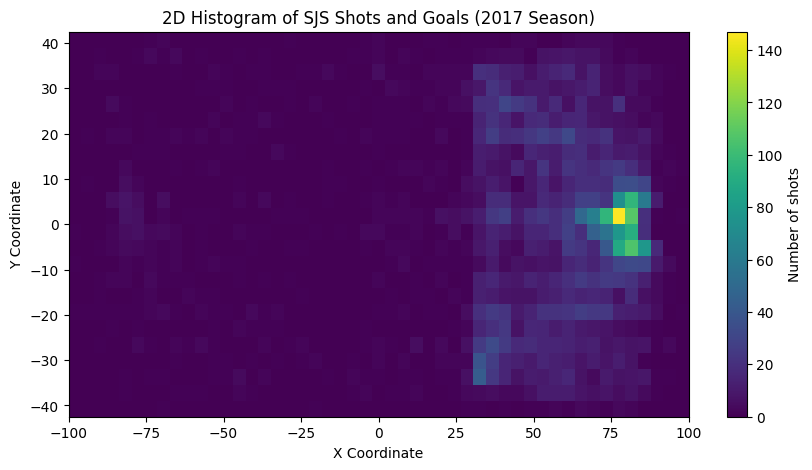

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins for histogram
x_bins = np.linspace(-100, 100, 50)
y_bins = np.linspace(-42.5, 42.5, 25)

# Create 2D histogram for SJS shots and goals
sjs_hist, x_edges, y_edges = np.histogram2d(sjs_data['coordinateX'], sjs_data['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, sjs_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of SJS Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

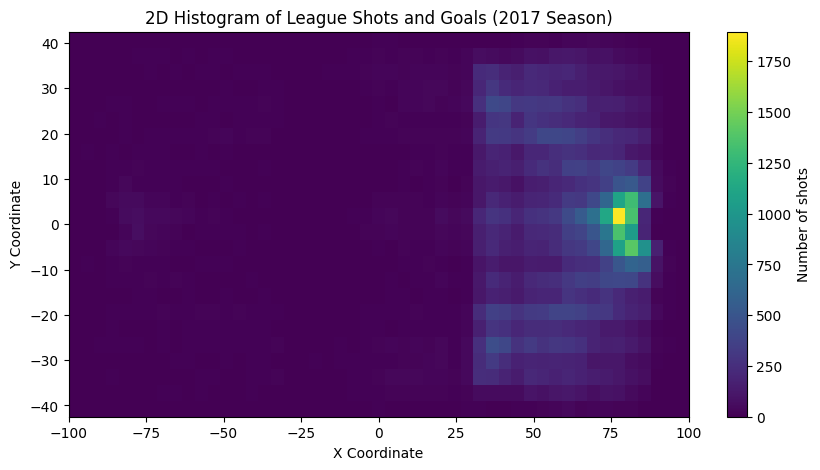

In [6]:
# Create 2D histogram for the entire league's shots and goals in 2017 season
league_hist, _, _ = np.histogram2d(league_data_2017['coordinateX'], league_data_2017['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, league_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of League Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [7]:
# Determine the number of games played by SJS in 2017
sjs_games_played = sjs_data['gameId'].nunique()

# Determine the total number of games in the league in 2017
total_league_games = league_data_2017['gameId'].nunique()

# Compute per-hour averages for histograms
sjs_hist_per_hour = sjs_hist / sjs_games_played
league_hist_per_hour = league_hist / total_league_games

sjs_games_played, total_league_games

(92, 1355)

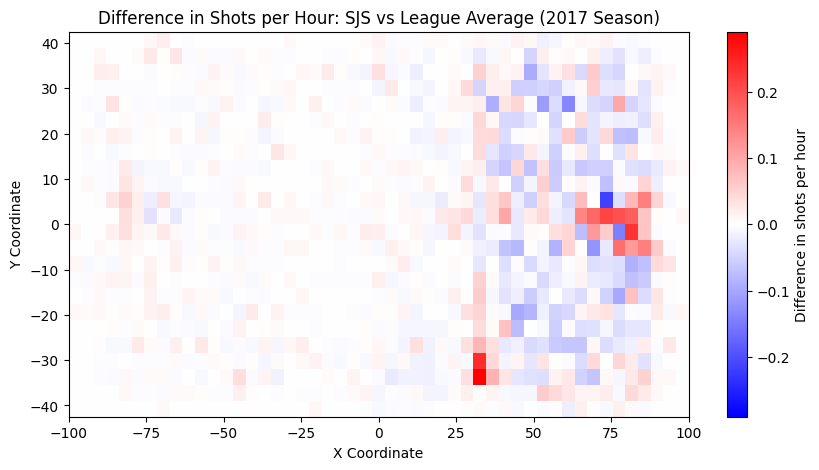

In [8]:
# Compute the difference between SJS and league averages
difference_hist = sjs_hist_per_hour - league_hist_per_hour

# Plot the difference histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, difference_hist.T, shading='auto', cmap='bwr', vmin=-difference_hist.max(), vmax=difference_hist.max())
plt.colorbar(label='Difference in shots per hour')
plt.title('Difference in Shots per Hour: SJS vs League Average (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [9]:
import requests

response = requests.get('https://statsapi.web.nhl.com/api/v1/teams')
data = response.json()
team_dict = {team['abbreviation']: team['name'] for team in data['teams']}

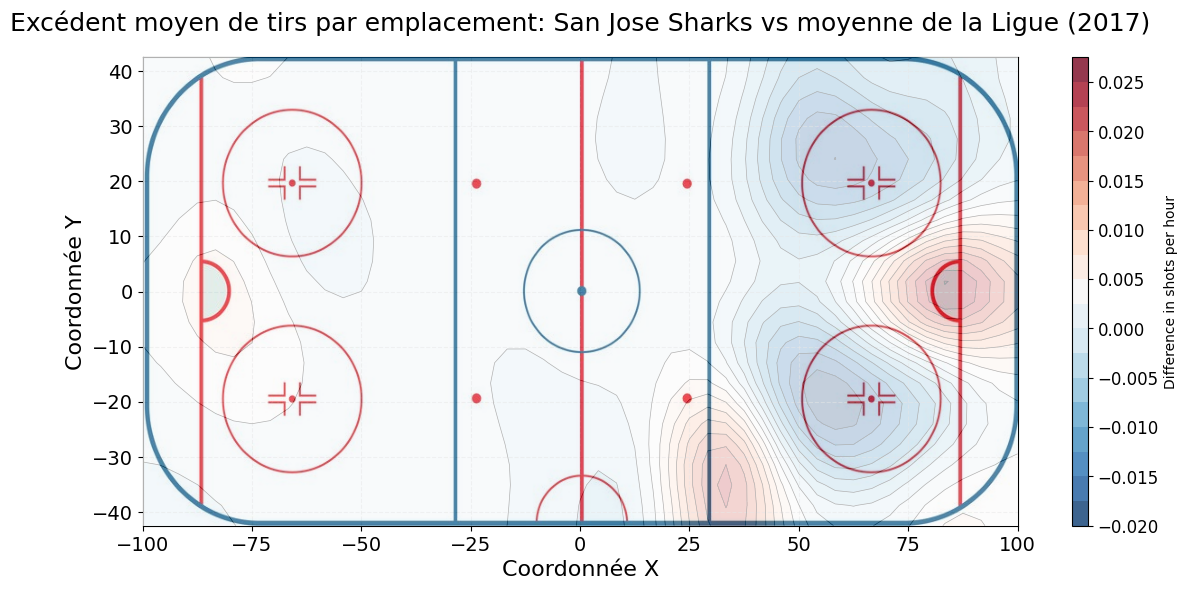

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from utils import unify_coordinates_referential
from matplotlib.colors import ListedColormap

def plot_team_vs_league(team_abbreviation, season_year):
    data = pd.read_csv("clean_data.csv")
    data = unify_coordinates_referential(data)

    team_full_name = team_dict.get(team_abbreviation, team_abbreviation)

    # Filter data for the specified season and team
    team_data = data[(data['season'] == season_year) & ((data['homeTeam'] == team_abbreviation) | (data['awayTeam'] == team_abbreviation))]

    # Filter data for the specified season for the entire league
    league_data = data[data['season'] == season_year]

    # Define bins for histogram
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42.5, 42.5, 25)

    # Create 2D histogram for team shots and goals
    team_hist, x_edges, y_edges = np.histogram2d(team_data['coordinateX'], team_data['coordinateY'], bins=[x_bins, y_bins])

    # Create 2D histogram for the entire league's shots and goals in the specified season
    league_hist, _, _ = np.histogram2d(league_data['coordinateX'], league_data['coordinateY'], bins=[x_bins, y_bins])

    # Determine the number of games played by the team in the specified season
    team_games_played = team_data['gameId'].nunique()
    # Determine the total number of games in the league in the specified season
    total_league_games = league_data['gameId'].nunique()
    # Compute per-hour averages for histograms
    team_hist_per_hour = team_hist / team_games_played
    league_hist_per_hour = league_hist / total_league_games

    # Compute the difference between the team and league averages
    difference_hist = team_hist_per_hour - league_hist_per_hour

    # Slightly reduce the Gaussian kernel smoothing
    smoothed_difference = gaussian_filter(difference_hist, sigma=2.5)

    # Load the hockey rink image
    correct_hockey_court_img = plt.imread('hocker_court.jpg')

    default_cmap = plt.cm.RdBu_r
    colors = default_cmap(np.linspace(0, 1, 256))
    # Modify alpha values for a smoother transition around zero difference
    alpha_gradient = np.linspace(0.2, 1, 256)
    colors[:, 3] = alpha_gradient
    
    transparent_cmap_final = ListedColormap(colors)

    # Plot aesthetics and visualization without topography numbers
    plt.figure(figsize=(12, 6))

    # Create filled contours for gradient appearance as the background
    filled_contour = plt.contourf(smoothed_difference.T, levels=20, cmap=transparent_cmap_final, alpha=0.8, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    cbar = plt.colorbar(filled_contour, label='Difference in shots per hour', aspect=30)
    cbar.ax.tick_params(labelsize=12)

    # Add refined contour lines without topography numbers
    plt.contour(smoothed_difference.T, levels=20, colors='k', linestyles='solid', linewidths=0.5, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

    # Overlay the hockey rink image on top of the visualization in the foreground with reduced opacity (alpha=0.7) and higher zorder
    plt.imshow(correct_hockey_court_img, aspect='auto', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], alpha=0.7, zorder=10)

    # Enhance title and labels to match desired aesthetic
    plt.title(f'Excédent moyen de tirs par emplacement: {team_full_name} vs moyenne de la Ligue ({season_year})', fontsize=18, y=1.04)
    plt.xlabel('Coordonnée X', fontsize=16)
    plt.ylabel('Coordonnée Y', fontsize=16)
    plt.xticks(fontsize=14,)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Example usage:
plot_team_vs_league('SJS', 2017)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
# from utils import unify_coordinates_referential  # Uncomment if you have this module
from matplotlib.colors import ListedColormap
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_plot(season_year):
    
    team_dropdown = widgets.Dropdown(
        options=team_dict.values(),
        description='Équipe:',
        disabled=False,
    )
    
    def update_plot(Team):
        team_abbreviation = [key for key, value in team_dict.items() if value == Team][0]
        plot_team_vs_league(team_abbreviation, season_year)
    
    control = widgets.interactive(update_plot, Team=team_dropdown)
    
    # Display only the dropdown and the output, not the repeated control.
    display(team_dropdown, control.children[-1])
    return control

from ipywidgets import IntSlider
from ipywidgets.embed import embed_minimal_html

embed_minimal_html('export.html', views=[interactive_plot(2017)], title='Widgets export')
# Call the function


Dropdown(description='Équipe:', options=('New Jersey Devils', 'New York Islanders', 'New York Rangers', 'Phila…

Output()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
# from utils import unify_coordinates_referential  # Uncomment if you have this module
from matplotlib.colors import ListedColormap
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_plot(season_year):
    
    team_dropdown = widgets.Dropdown(
        options=team_dict.values(),
        description='Équipe:',
        disabled=False,
    )
    
    def update_plot(Team):
        team_abbreviation = [key for key, value in team_dict.items() if value == Team][0]
        plot_team_vs_league(team_abbreviation, season_year)
    
    control = widgets.interactive(update_plot, Team=team_dropdown)
    
    # Display only the dropdown and the output, not the repeated control.
    display(team_dropdown, control.children[-1])

# Call the function
interactive_plot(2016)

Dropdown(description='Équipe:', options=('New Jersey Devils', 'New York Islanders', 'New York Rangers', 'Phila…

Output()

In [16]:


from ipywidgets import StaticInteract, RangeWidget
StaticInteract(plot_team_vs_league,
               team_abbreviation=widgets.Dropdown(
                    options=team_dict.values(),
                    description='Équipe:',
                    disabled=False,
                ),
               season_year=RangeWidget(2016, 2019, 1))



ImportError: cannot import name 'StaticInteract' from 'ipywidgets' (/home/lolo/Documents/UDEM_courses/session_automne_2023/data_science/projet_NHL_repo/IFT6758_NHL/venv/lib/python3.11/site-packages/ipywidgets/__init__.py)